## IMPORT

In [15]:
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display_html

## PATH

In [4]:
ROOT = Path.cwd().parent

data_path = ROOT / 'data'

## LOAD DATA

In [12]:
data_long = pd.read_csv(data_path / 'Country_to_USA.csv')

In [20]:
df = data_long.pivot(index='month', columns='country', values='export_value').reset_index()

In [21]:
df['month'] = pd.to_datetime(df['month'])

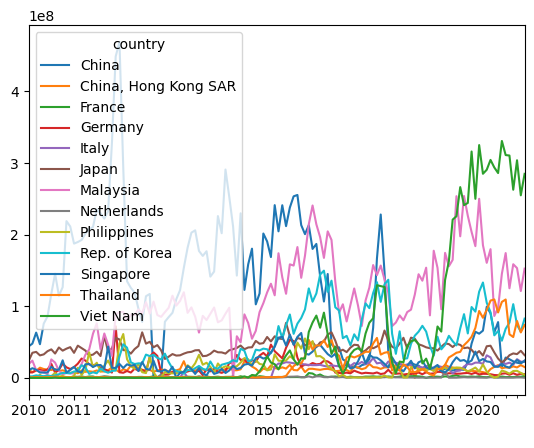

In [23]:
df.set_index('month').plot()
plt.show()

In [27]:
total_exports = df.set_index('month').sum().sort_values(ascending=False)
top_3_countries = total_exports.head(3).index.tolist()
print(top_3_countries)

['China', 'Malaysia', 'Viet Nam']


## LOTKA VOLTERRA BASICO

In [28]:
df_top3 = df[top_3_countries].copy()

# Fill missing values (optional)
df_top3 = df_top3.fillna(method='ffill').fillna(method='bfill')

# Normalize (optional but helps with scaling)
df_top3 = df_top3 / df_top3.max()


C:\Users\Leonardo\AppData\Local\Temp\ipykernel_26968\1758831734.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_top3 = df_top3.fillna(method='ffill').fillna(method='bfill')


In [25]:
data_long['country'].unique()

array(['China', 'China, Hong Kong SAR', 'France', 'Germany', 'Italy',
       'Japan', 'Malaysia', 'Netherlands', 'Philippines', 'Singapore',
       'Thailand', 'Rep. of Korea', 'Viet Nam'], dtype=object)

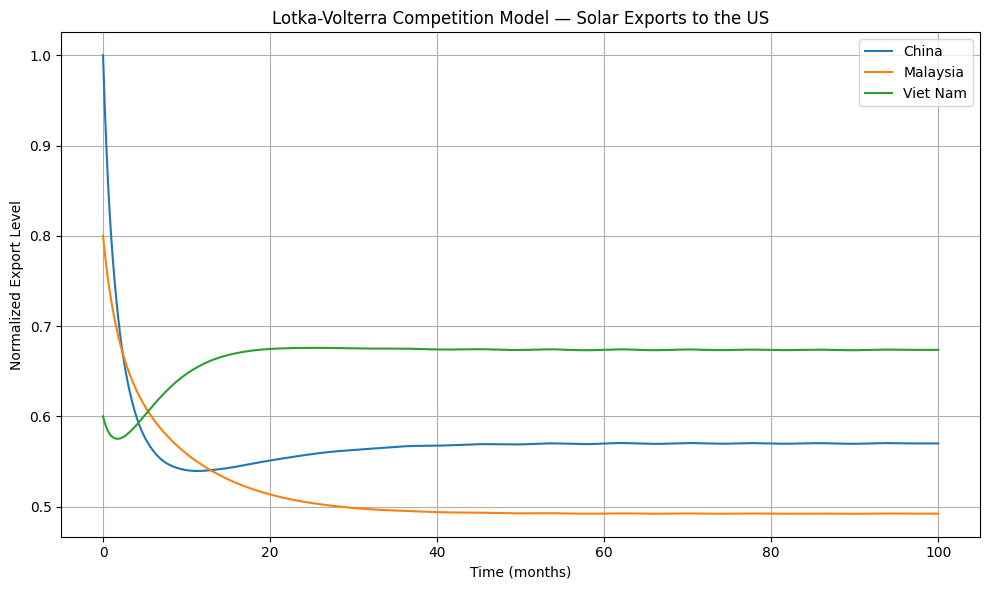

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def lotka_volterra_explicit(t, X, r1, r2, r3,
                             a11, a12, a13,
                             a21, a22, a23,
                             a31, a32, a33):
    x1, x2, x3 = X

    dx1dt = r1 * x1 * (1 - a11 * x1 - a12 * x2 - a13 * x3)
    dx2dt = r2 * x2 * (1 - a21 * x1 - a22 * x2 - a23 * x3)
    dx3dt = r3 * x3 * (1 - a31 * x1 - a32 * x2 - a33 * x3)

    return [dx1dt, dx2dt, dx3dt]

# Parameters
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0
}

# Initial conditions
X0 = [1.0, 0.8, 0.6]

# Time span and evaluation points
t_span = (0, 100)
t_eval = np.linspace(*t_span, 500)

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_explicit(t, X, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval,
    method='RK45'
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='Malaysia')
plt.plot(sol.t, sol.y[2], label='Viet Nam')
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## CALIBRATION

In [38]:
from scipy.optimize import least_squares

china_data = df_top3['China']
malaysia_data = df_top3['Malaysia']
vietnam_data = df_top3['Viet Nam']

# Stack data for comparison
data = np.vstack([china_data, malaysia_data, vietnam_data])  # shape (3, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [39]:
def residuals(params, X0, t_data, data):
    r1, r2, r3 = params[:3]
    a11, a12, a13 = params[3:6]
    a21, a22, a23 = params[6:9]
    a31, a32, a33 = params[9:]

    # Solve the system with these parameters
    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_explicit(t, X, r1, r2, r3,
                                                 a11, a12, a13,
                                                 a21, a22, a23,
                                                 a31, a32, a33),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data,
        method='RK45'
    )

    # Compute difference between model and data
    if sol.y.shape[1] != len(t_data):  # catch integration failure
        return np.ones(data.size) * 1e6

    return (sol.y - data).ravel()  # flatten to 1D for least_squares


In [40]:
# Initial guess
initial_guess = [0.5, 0.3, 0.4,   # r1, r2, r3
                 1.0, 0.6, 0.2,   # a11, a12, a13
                 0.3, 1.0, 0.5,   # a21, a22, a23
                 0.4, 0.2, 1.0]   # a31, a32, a33

# Initial export levels from your data
X0 = data[:, 0]

# Fit the model
result = least_squares(residuals, initial_guess, args=(X0, t_data, data),
                       bounds=(0, 10))  # optional: constrain params to be positive

# Extract best-fit parameters
fitted_params = result.x


In [41]:
fitted_params

array([0.27224774, 0.14704997, 3.20012163, 1.37841366, 1.53004559,
       6.51895476, 1.14600674, 1.38692691, 0.5       , 0.4       ,
       0.2       , 1.        ])

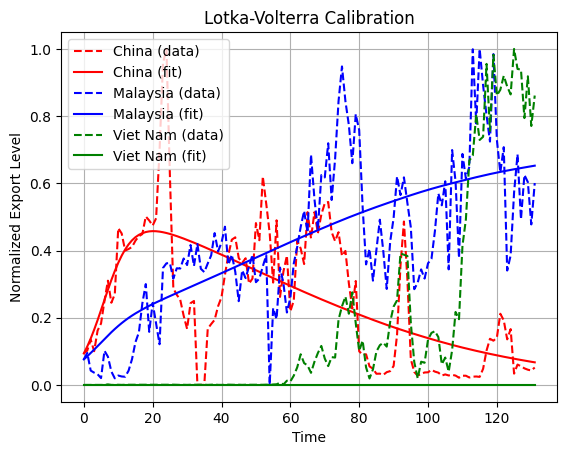

In [43]:
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_explicit(t, X, *fitted_params),
    t_span=(t_data[0], t_data[-1]),
    y0=X0,
    t_eval=t_data
)

# Plot
plt.plot(t_data, data[0], 'r--', label='China (data)')
plt.plot(t_data, sol.y[0], 'r-', label='China (fit)')
plt.plot(t_data, data[1], 'b--', label='Malaysia (data)')
plt.plot(t_data, sol.y[1], 'b-', label='Malaysia (fit)')
plt.plot(t_data, data[2], 'g--', label='Viet Nam (data)')
plt.plot(t_data, sol.y[2], 'g-', label='Viet Nam (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()
